<a href="https://colab.research.google.com/github/Homabeyrami/Image-Classification/blob/main/Image_Classification_with_Convolutional_Neural_Networks_(CNNs)2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with CNNs



## Introduction

In this project, we aim to build, train, and validate Convolutional Neural Networks (ConvNets) using the CIFAR-10 dataset. The CIFAR-10 dataset is widely used in the computer vision and machine learning communities to benchmark new algorithms and network architectures.

CIFAR-10 is a dataset that contains small RGB images (32x32 pixels) of ten different classes:

    * airplane
    * automobile
    * bird
    * cat
    * deer
    * dog
    * frog
    * horse
    * ship
    * truck
More details about the dataset can be found at the following link: https://www.cs.toronto.edu/~kriz/cifar.html

Based on a comprehensive review from [Papers with Code](https://paperswithcode.com/sota/image-classification-on-cifar-10), the current state-of-the-art results on this dataset have reached an accuracy of 99.7%. However, in this assignment, we aim to achieve a substantial accuracy improvement using various techniques such as Data Augmentation, Batch Normalization, Dropout, and Learning Rate Schedulers.



Tasks

To achieve our goal, we will implement and optimize the following tasks:

    * Split Data and Build Convolutional Networks
    * Train Convolutional Networks
    * Add Dropout Layers
    * Add Batch Normalization
    * Experiment with Initialization Strategies
    * Experiment with Different Activation Functions
    * Add L2 Regularization
    * Apply Data Augmentation
    * Experiment with Different Architectures
    * Monitor the Training Procedure




Project Workflow

We will follow a structured workflow to ensure a thorough and systematic approach to improving our ConvNet model:

Data Loading and Preprocessing
Building the Initial CNN Model
Implementing and Testing Each Optimization Technique
Evaluating the Model Performance
With each step, we will document our findings and improvements to provide a comprehensive report on our journey towards achieving higher accuracy.

## Data
Data
We will train our ConvNet using the CIFAR-10 dataset, which contains 60,000 color images of 32x32 pixels divided into 10 classes. The dataset is split into 50,000 training images and 10,000 test images. The training data is further divided into training and validation sets. The provided test set is used for final evaluation.

## Getting Started

 To begin, we first mount our Google Drive to access the dataset and any additional resources required for the project.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import numpy as np
import os  # Operation system
import pickle
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)
from tqdm import tnrange, tqdm_notebook
from IPython import display
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, activations, regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
from tensorflow.keras.callbacks import EarlyStopping

import time # Import the time module
from IPython import display # Import the display module

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from time import time, sleep
from IPython.display import display, clear_output

# Check available devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7236637126848378289
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5431355578220713959
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


### Download CIFAR10 data
Data Loading and Preprocessing
Now, we load the CIFAR-10 dataset and preprocess it. The dataset contains 5 batches for training/validation and 1 batch for testing. We will split the data into training and validation sets and normalize the images.

In [ ]:
# URL for downloading the data
origin_url = 'https://surfdrive.surf.nl/files/index.php/s/{key}/download'

# Dictionary mapping file names to download keys
files = {
    'cifar10-batch-1': '4Nee36XgbYjp3N6',
    'cifar10-batch-2': 'LVx85dLceKI5toF',
    'cifar10-batch-3': '4FoFmeKyXa5sYr0',
    'cifar10-batch-4': 'a4o2RatC0Fa3Exb',
    'cifar10-batch-5': 'eqBJRWdkRGk025k',
    'cifar10-test': 'nEf9Z4eg7iGmWGU'
}

# Download files to local drive (only downloads the files once)
local_files = []
for name, key in files.items():
    url = origin_url.format(key=key)
    print(f"Downloading data from {url}")
    file_path = get_file(name, origin=url)
    local_files.append({'name': name, 'file': file_path})

print("All files downloaded.")

# Load all batches into memory
print("Loading batches into memory...")
batches = {lf['name']: pickle.load(open(lf['file'], 'rb'), encoding='latin1') for lf in local_files}
print("All batches loaded.")

# Convert data to float format and reshape to correct format
# This part is specific to CIFAR-10
print("Converting data to float format and reshaping...")
for batch in batches.values():
    # Images were originally in (CxWxH) format, convert to (WxHxC)
    batch['data'] = (batch['data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) / 255.).astype("float32")

data_size_in = (32, 32, 3)
n_classes = 10
print("Data conversion and reshaping completed.")



All files downloaded.
Loading batches into memory...
All batches loaded.
Converting data to float format and reshaping...
Data conversion and reshaping completed.


The CIFAR dataset is now loaded in memory in the form of a Python dictionary. To get to know your data, check what are the keys of such a dictionary:

In [ ]:
print(batches.keys())

dict_keys(['cifar10-batch-1', 'cifar10-batch-2', 'cifar10-batch-3', 'cifar10-batch-4', 'cifar10-batch-5', 'cifar10-test'])


Before you define your datasets, it is useful to check the distribution of labels across batches of CIFAR10, in case some batches have skewed distributions of labels.
In order to do that, you can use visualize the histogram of labels using the function ```hist()``` of the matplotlib library:

    plt.hist()

# Reviewing Data Distribution
Before defining our datasets, it's essential to check the distribution of labels across different batches of the CIFAR-10 dataset. If some batches have skewed distributions, it might affect the performance of the network. Using the hist function from the matplotlib library, we visualize the histogram of labels.

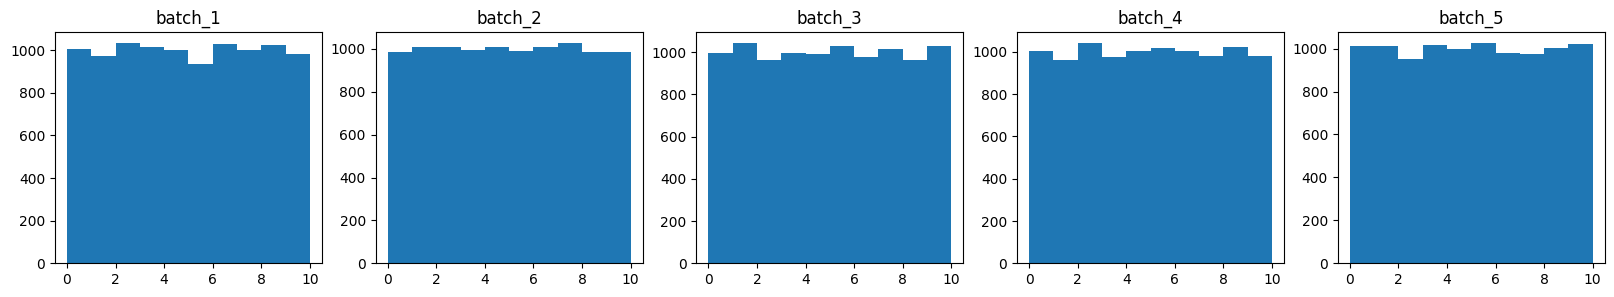

Data distribution review completed.


In [ ]:
# Reviewing Data Distribution
fig = plt.figure(figsize=(20, 3))
for i in range(1, 6):
    plt.subplot(1, 5, i)
    plt.hist(batches[f'cifar10-batch-{i}']['labels'], bins=range(11))
    plt.title(f'batch_{i}')
plt.show()

print("Data distribution review completed.")


Conclusion

The histograms show that the label distribution in each batch is balanced and not skewed. Therefore, no special arrangements are needed for creating training and validation sets.









# Loading Data

Next, we use the load_data function to load the CIFAR-10 dataset and split it into training, validation, and test sets. This function also displays general information about the shape of the tensors and the number of labels to ensure everything is loaded correctly.

In [ ]:
# Load CIFAR-10 data
(train_x, train_y), (test_x, test_y) = cifar10.load_data()

# Split training data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Normalize the images to the range [0, 1]
train_x = train_x.astype('float32') / 255.0
val_x = val_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
train_y_one_hot = to_categorical(train_y, 10)
val_y_one_hot = to_categorical(val_y, 10)
test_y_one_hot = to_categorical(test_y, 10)

# Print shapes to confirm
print(f"Training data shape: {train_x.shape}")
print(f"Training labels shape: {train_y_one_hot.shape}")
print(f"Validation data shape: {val_x.shape}")
print(f"Validation labels shape: {val_y_one_hot.shape}")
print(f"Test data shape: {test_x.shape}")
print(f"Test labels shape: {test_y_one_hot.shape}")


Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000, 10)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000, 10)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 10)


# Check validation performance before training

 All the main components required to train our network have been defined now. However, we have seen that in order to properly monitor the behavior of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible. For this purpose, you can use the function network.evaluate in Keras, and set the batch_size to a value that fits in your GPU/CPU.




In [ ]:
# Define the model
model = Sequential()

# Add convolutional layers with batch normalization and max pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(GlobalAveragePooling2D())

# Add dense layers with dropout for regularization
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_45 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 batch_normalization_46 (Ba  (None, 13, 13, 64)        256       
 tchNormalization)                                               
                                                        

### Check validation performance before training
All the main components required to train our network have been defined now.
However, we have seen that in order to properly monitor the behaviour of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible.
For this purpose, you can use the function ```network.evaluate``` in Keras, and set the ```batch_size``` to a value that fits in your GPU/CPU.

In [ ]:
# Evaluate model performance before training
scores = model.evaluate(val_x, val_y_one_hot, batch_size=32)
print(f'Initial validation accuracy = {scores[1]:.2f}')



313/313 [==============================] - 3s 4ms/step - loss: 2.3046 - accuracy: 0.0933
Initial validation accuracy = 0.09


# Define your network builder function. We build a convolutional network that contains:
 1. Input layer
 2. Convolutional layer
 3. Max pooling layer
 4. Convolutional layer
 5. Max pooling layer
 6. Fully-connected layer(s)
 7. Softmax layer


In [ ]:
def build_neural_network(data_size_in, n_classes):
    # Feature extraction with CNNs
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    network_2 = layers.MaxPooling2D(pool_size=(2, 2))(network_1)

    network_3 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(network_2)
    network_4 = layers.MaxPooling2D(pool_size=(2, 2))(network_3)

    network_5 = layers.Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same')(network_4)
    network_6 = layers.MaxPooling2D(pool_size=(2, 2))(network_5)

    network_7 = layers.Flatten()(network_6)

    # Classification with MLP
    network_8 = layers.Dense(256, activation='relu')(network_7)
    network_8 = layers.Dropout(0.5)(network_8)
    prediction = layers.Dense(n_classes, activation='softmax')(network_8)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model

# Example of building the model
data_size_in = (32, 32, 3)
n_classes = 10
model = build_neural_network(data_size_in, n_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_50 (Conv2D)          (None, 8, 8, 128)         2049

## Check validation performance before training

 All the main components required to train our network have been defined now. However, we have seen that in order to properly monitor the behavior of a network during training, we should check the performance (the accuracy) on a separate validation set, and see if it returns something sensible. For this purpose, you can use the function network.evaluate in Keras, and set the batch_size to a value that fits in your GPU/CPU.

In [ ]:
# Evaluate model performance before training
scores = model.evaluate(val_x, val_y_one_hot, batch_size=32)
print(f'Initial validation accuracy = {scores[1]:.2f}')


313/313 [==============================] - 2s 3ms/step - loss: 2.3077 - accuracy: 0.0991
Initial validation accuracy = 0.10


# Improving Model Accuracy



Given the initial validation accuracy of around 9%, it is evident that the model requires improvement. Several methods can be tried to enhance the model's accuracy:

Increase the Number of Layers and Units: Adding more layers and neural units can help the model learn more complex features.
Increase Epochs: Increasing the number of training epochs can allow the model to learn better.
Use Data Augmentation Techniques: More data augmentation techniques can be used to improve the model's learning.
Hyperparameter Tuning: Experimenting with different hyperparameter settings, such as learning rate, batch size, etc., can lead to better performance
mproving Model Accuracy
Given the initial validation accuracy of around 9%, it is evident that the model requires improvement. Several methods can be tried to enhance the model's accuracy:

1. Increase the Number of Layers and Units
Adding more layers and neural units can help the model learn more complex features.

2. Increase Epochs
Increasing the number of training epochs can allow the model to learn better.

3. Use Data Augmentation Techniques
More data augmentation techniques can be used to improve the model's learning.

4. Hyperparameter Tuning
Experimenting with different hyperparameter settings, such as learning rate, batch size, etc., can lead to better performance.

In [ ]:
# Define an improved network architecture
def build_improved_network(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    print(model.summary())
    return model

# Build and compile the improved model
data_size_in = (32, 32, 3)
n_classes = 10
improved_model = build_improved_network(data_size_in, n_classes)
improved_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_57 (Ba  (None, 32, 32, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_60 (Conv2D)          (None, 16, 16, 128)       7385

In [ ]:
# Define the training function
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):
    # Lists to store values during training for visualization purposes
    tra_losses, tra_accs, val_losses, val_accs = [], [], [], []
    best_validation_accuracy = 0  # Variable to store the best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train the network
        results = network.fit(x_training, y_training, batch_size=batch_size, epochs=1, verbose=1)

        # Get training loss and accuracy
        training_loss = results.history['loss'][0]
        training_accuracy = results.history['accuracy'][0]
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x_validation, y_validation, batch_size=batch_size, verbose=0)
        validation_loss = scores[0]
        validation_accuracy = scores[1]
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        print(f"Epoch {epoch+1}/{n_epoch} - time: {(time.time()-st):.2f}s - loss: {training_loss:.4f} - accuracy: {training_accuracy:.4f} - val_loss: {validation_loss:.4f} - val_accuracy: {validation_accuracy:.4f}")

        # (Possibly) update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b', label='training loss')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c', label='training accuracy')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm', label='validation loss')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r', label='validation accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(f'Best validation accuracy = {best_validation_accuracy * 100:.2f}%')
        display.clear_output(wait=True) # Now using the correct display module
        display.display(plt.gcf())
        time.sleep(0.2)

    return tra_losses, tra_accs, val_losses, val_accs

In [ ]:
# Re-load the model found for the best accuracy
best_network = keras.models.load_model(network_filepath)

# Define the network name and perform prediction on the test set
network_name = 'network_task_2'
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)
# Create the 'results' directory if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')
# Write CSV files with outputs
output_filepath = os.path.join('results', f'{network_name}.csv')
with open(output_filepath, 'w') as ho:
    ho.write('filename,label\n')
    for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
        ho.write(f'{filename},{label}\n')


79/79 [==============================] - 1s 5ms/step


# Dropout

In [ ]:
def build_neural_network_bn_drop(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.MaxPooling2D(pool_size=(2, 2))(network_2)
    network_4 = layers.Dropout(0.3)(network_3)  # Adjusted dropout rate

    network_5 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(network_4)
    network_6 = layers.BatchNormalization()(network_5)
    network_7 = layers.MaxPooling2D(pool_size=(2, 2))(network_6)
    network_8 = layers.Dropout(0.3)(network_7)  # Adjusted dropout rate

    network_9 = layers.Flatten()(network_8)
    network_10 = layers.Dense(128, activation='relu')(network_9)
    network_11 = layers.BatchNormalization()(network_10)
    network_12 = layers.Dropout(0.5)(network_11)

    prediction = layers.Dense(n_classes, activation='softmax')(network_12)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model


In [ ]:
# Define data size and number of classes
data_size_in = (32, 32, 3)
n_classes = 10


In [ ]:
# Define batch size and number of epochs
batch_size = 64  # Experiment with different batch sizes
n_epoch = 20  # Increase the number of epochs


In [ ]:
# Define file directory and network filepath
file_dir = './'
network_filepath = os.path.join(file_dir, 'best_model_net_dropout.h5')


Building the Neural Network with Batch Normalization and Dropout

In [ ]:
# Define the model architecture with Batch Normalization and Dropout
def build_neural_network_bn_drop(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    network_1 = layers.Conv2D(32, kernel_size=(5, 5), activation='relu', padding='same')(inputs)
    network_2 = layers.BatchNormalization()(network_1)
    network_3 = layers.MaxPooling2D(pool_size=(2, 2))(network_2)
    network_4 = layers.Dropout(0.3)(network_3)  # Adjusted dropout rate

    network_5 = layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same')(network_4)
    network_6 = layers.BatchNormalization()(network_5)
    network_7 = layers.MaxPooling2D(pool_size=(2, 2))(network_6)
    network_8 = layers.Dropout(0.3)(network_7)  # Adjusted dropout rate

    network_9 = layers.Flatten()(network_8)
    network_10 = layers.Dense(128, activation='relu')(network_9)
    network_11 = layers.BatchNormalization()(network_10)
    network_12 = layers.Dropout(0.5)(network_11)

    prediction = layers.Dense(n_classes, activation='softmax')(network_12)

    model = Model(inputs=inputs, outputs=prediction)
    print(model.summary())

    return model


Training Function with Visualization

In [ ]:
# Training function with visualization
def train_network(network, x_training, y_training, x_validation, y_validation, n_epoch, batch_size, network_filepath):
    # Lists to store values during training for visualization purposes
    tra_losses = []  # list for training loss
    tra_accs = []  # list for training accuracy
    val_losses = []  # list for validation loss
    val_accs = []  # list for validation accuracy

    # Store the best validation accuracy and save the parameters to disk
    best_validation_accuracy = 0  # best validation accuracy

    for epoch in range(n_epoch):
        st = time.time()

        # Train the network
        results = network.fit(x_training, y_training, batch_size=batch_size, epochs=1, verbose=1)

        # Get training loss and accuracy
        training_loss = results.history['loss'][0]
        training_accuracy = results.history['accuracy'][0]

        # Add to lists
        tra_losses.append(training_loss)
        tra_accs.append(training_accuracy)

        # Evaluate performance (loss and accuracy) on validation set
        scores = network.evaluate(x=x_validation, y=y_validation, batch_size=batch_size, verbose=0)
        validation_loss = scores[0]
        validation_accuracy = scores[1]

        # Add to lists
        val_losses.append(validation_loss)
        val_accs.append(validation_accuracy)

        # Update best validation accuracy and save the network
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            network.save(network_filepath)

        # Visualization of the learning curves
        fig = plt.figure(figsize=(10, 5))
        tra_loss_plt, = plt.plot(range(len(tra_losses)), tra_losses, 'b')
        tra_accs_plt, = plt.plot(range(len(tra_accs)), tra_accs, 'c')
        val_loss_plt, = plt.plot(range(len(val_losses)), val_losses, 'm')
        val_acc_plt, = plt.plot(range(len(val_accs)), val_accs, 'r')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend([tra_loss_plt, tra_accs_plt, val_loss_plt, val_acc_plt],
                   ['training loss', 'training accuracy', 'validation loss', 'validation accuracy'],
                   loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Best validation accuracy = {:.2f}%'.format(100. * best_validation_accuracy))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.2)


Compiling the Model with Adjusted Parameters

In [ ]:
# Compile the model with adjusted parameters
network = build_neural_network_bn_drop(data_size_in, n_classes)
network.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_60 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_63 (Conv2D)          (None, 16, 16, 64)        5126

Training the Network and Displaying Results

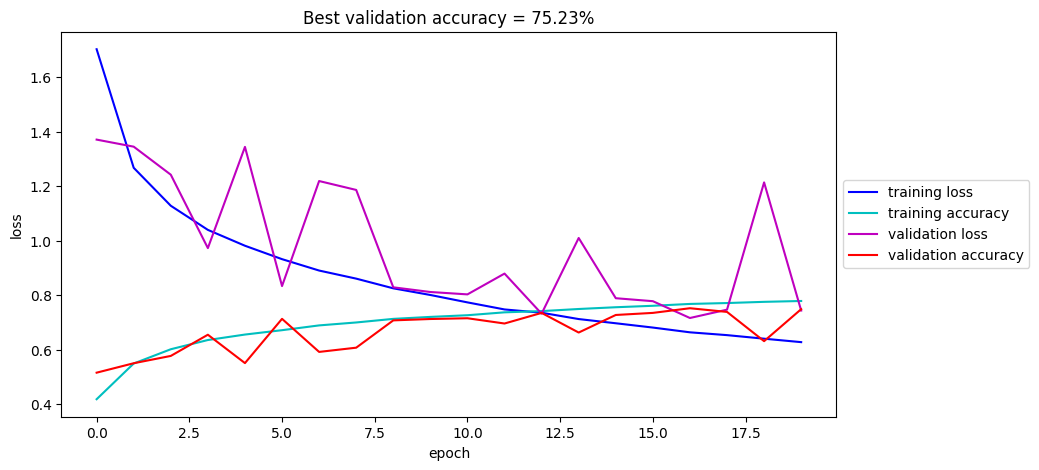

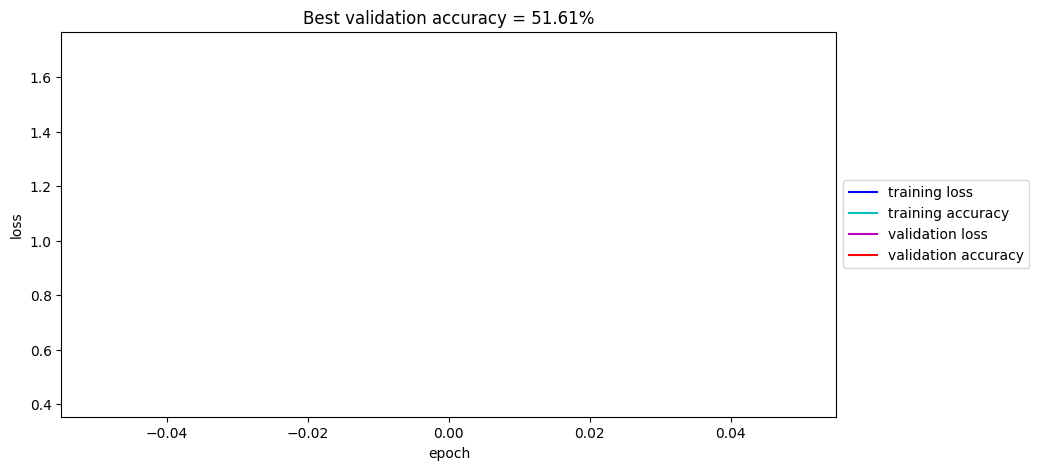

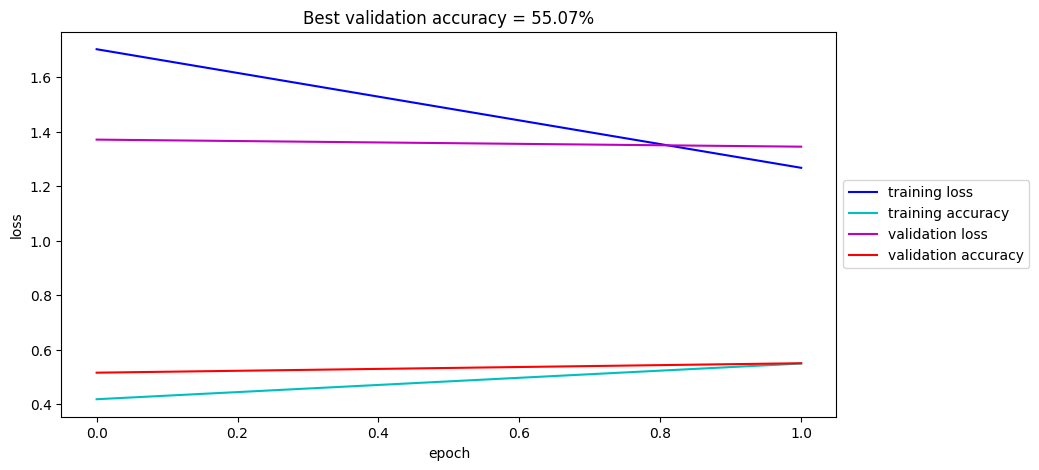

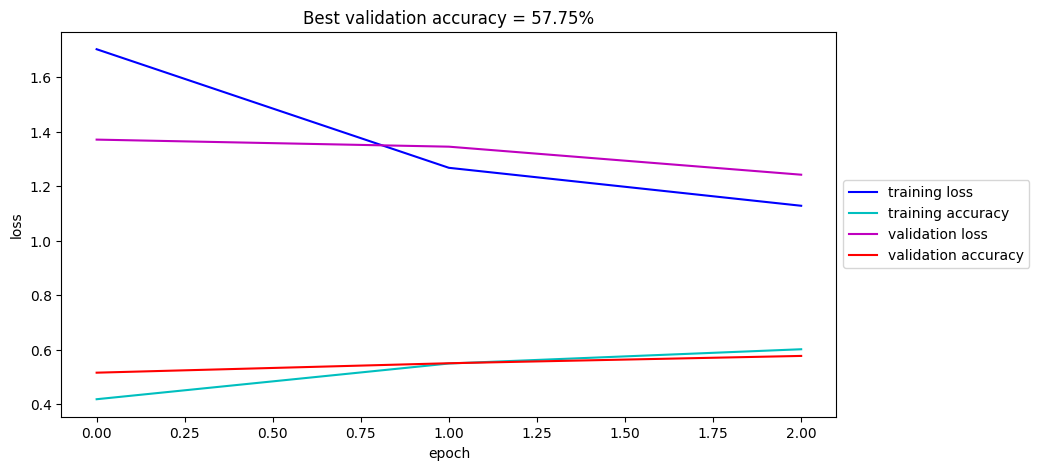

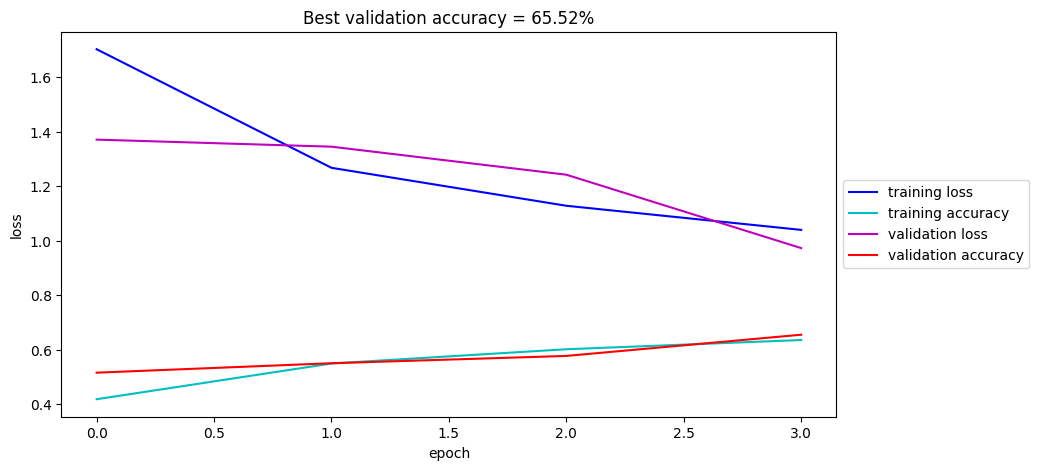

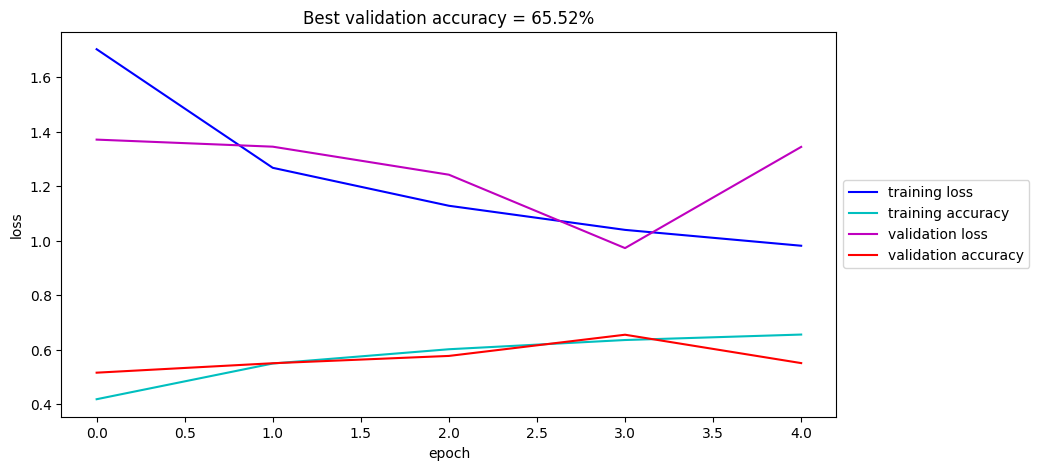

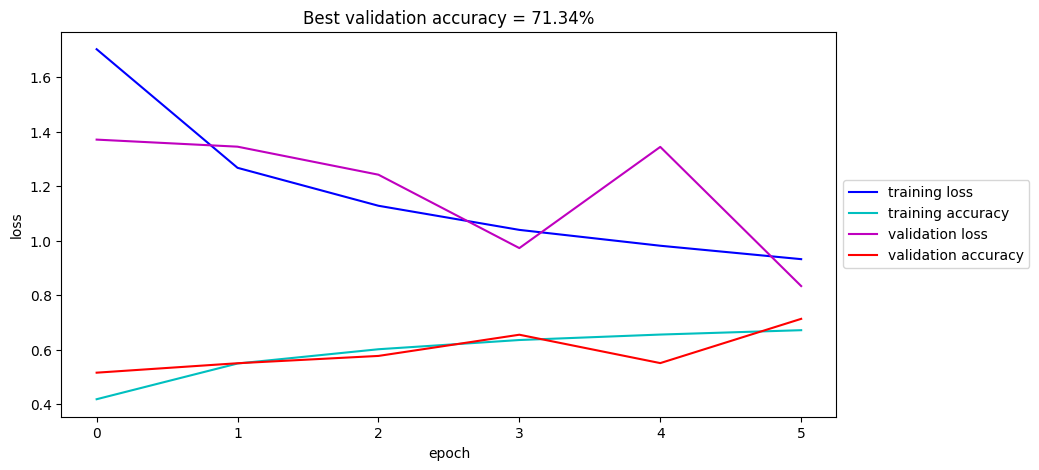

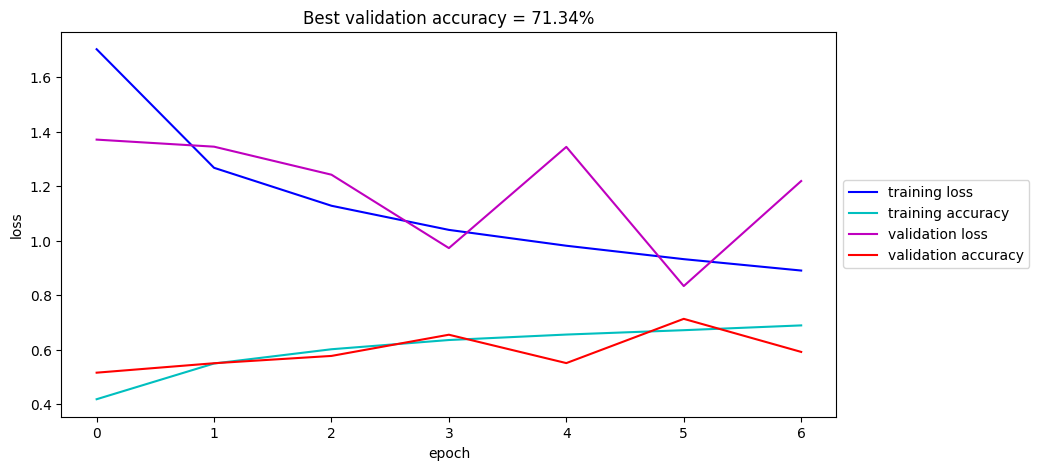

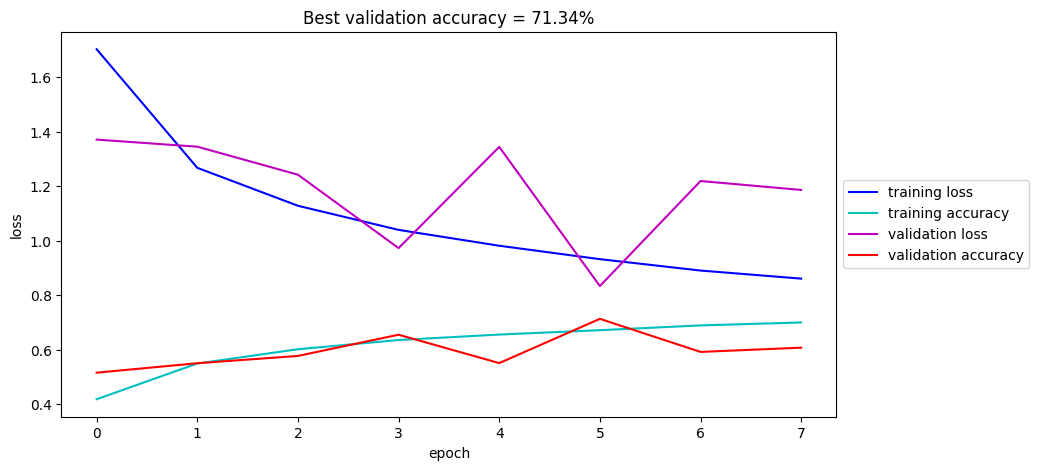

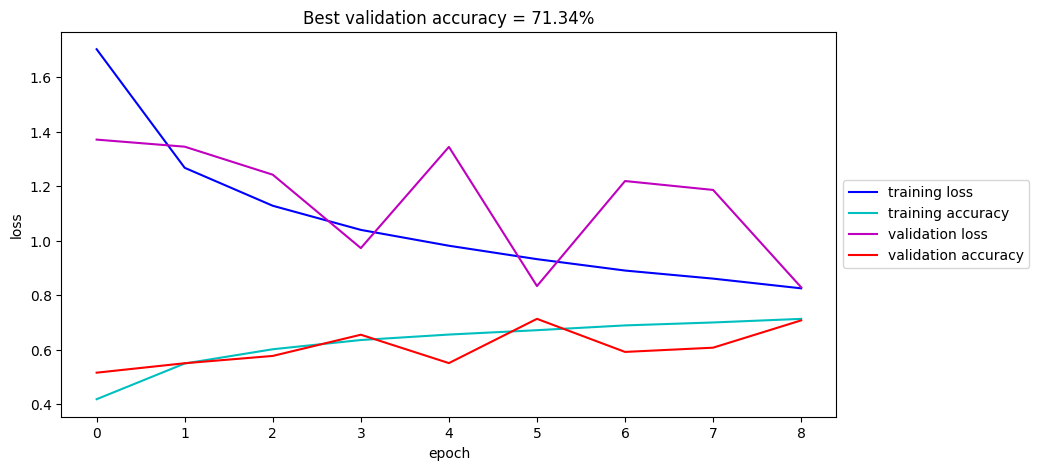

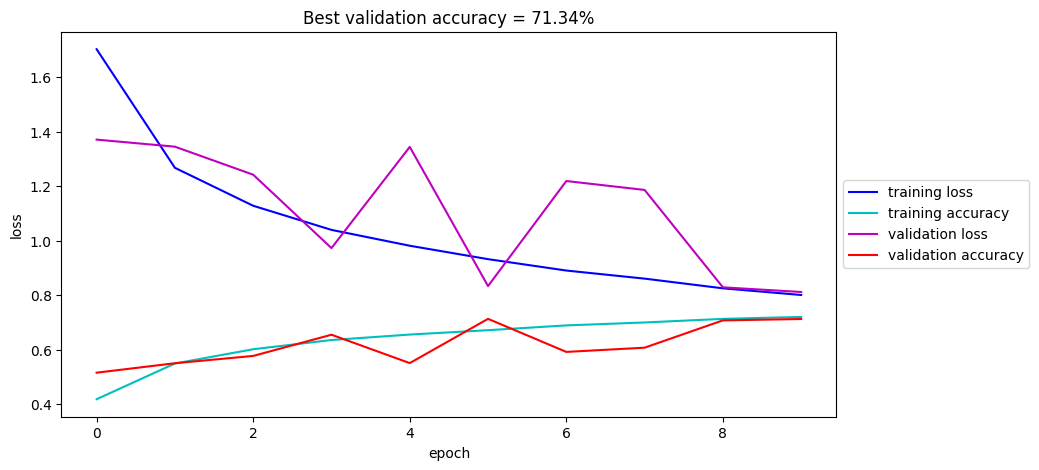

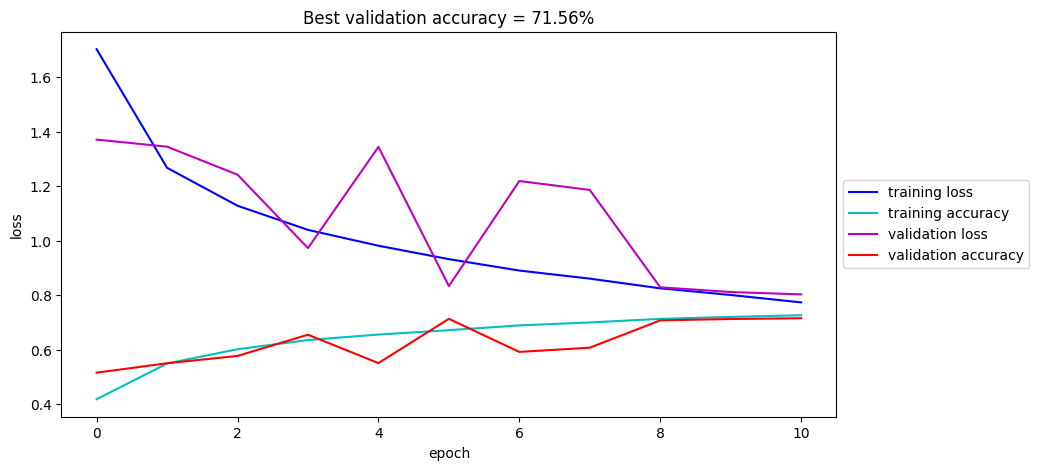

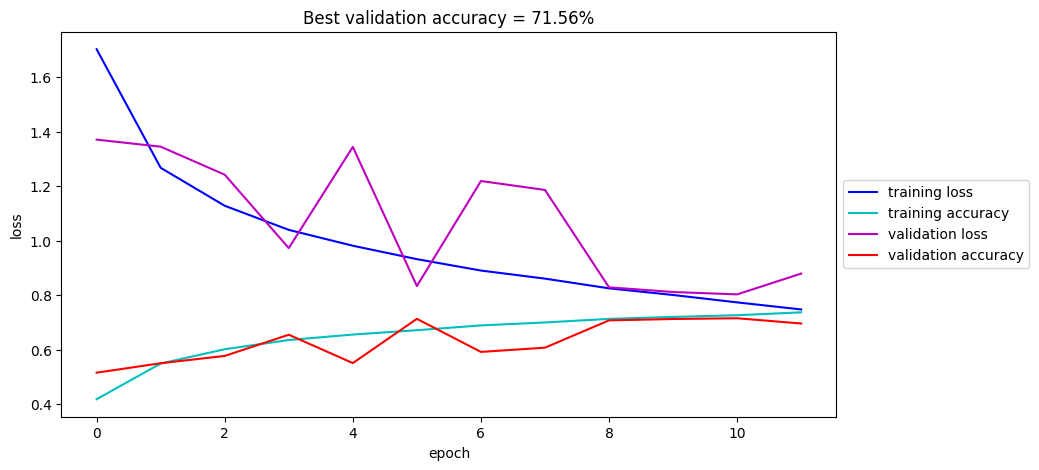

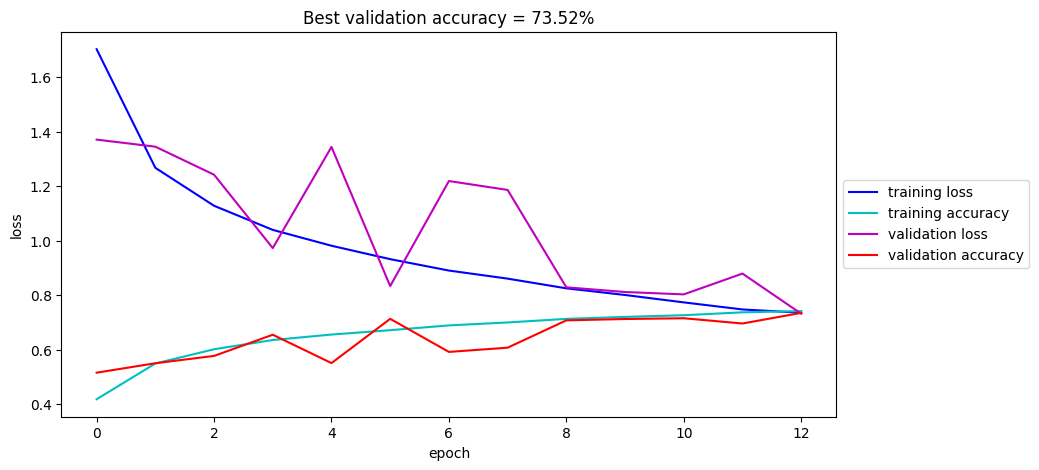

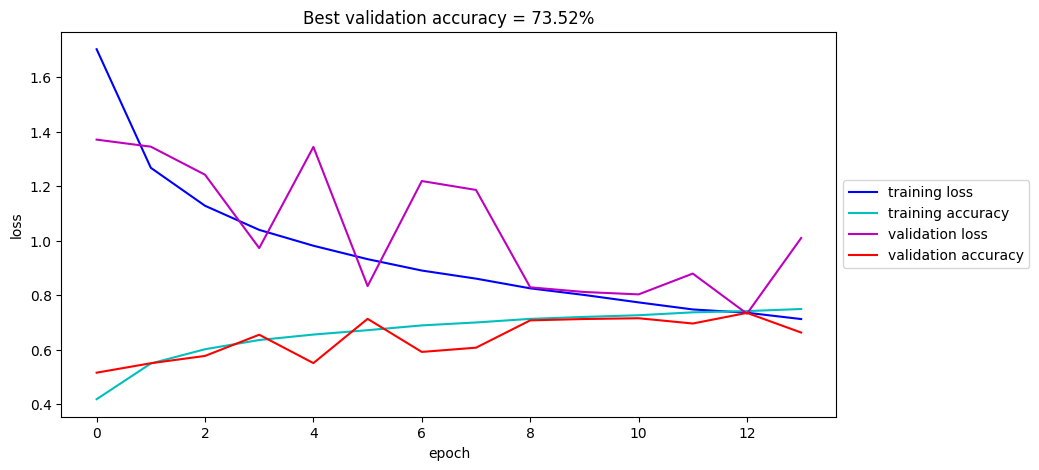

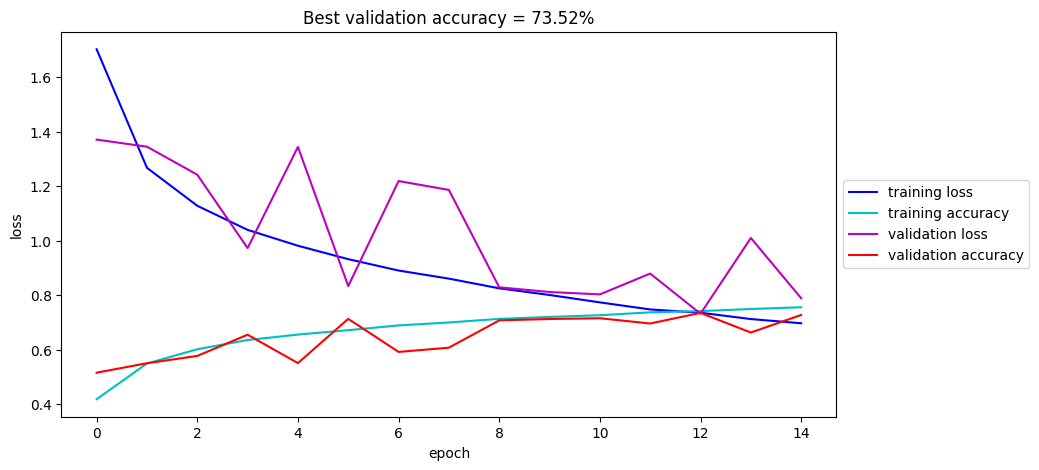

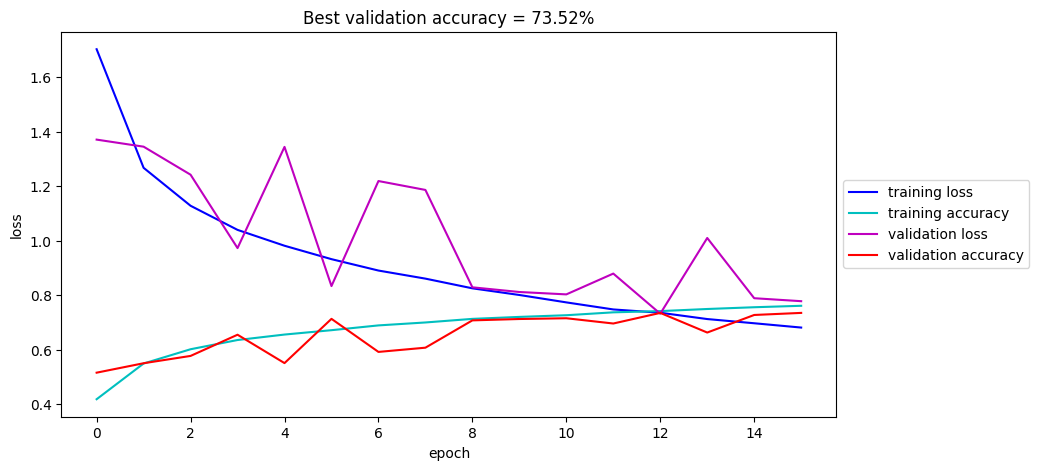

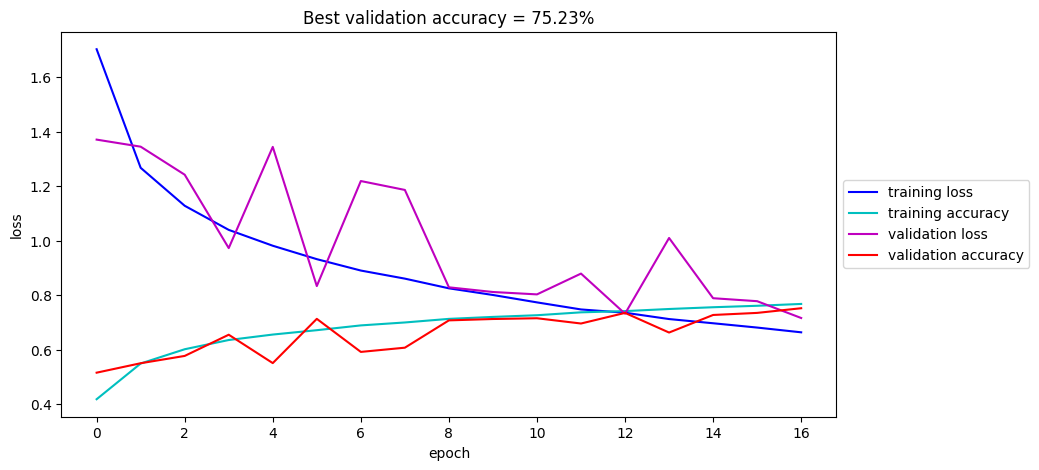

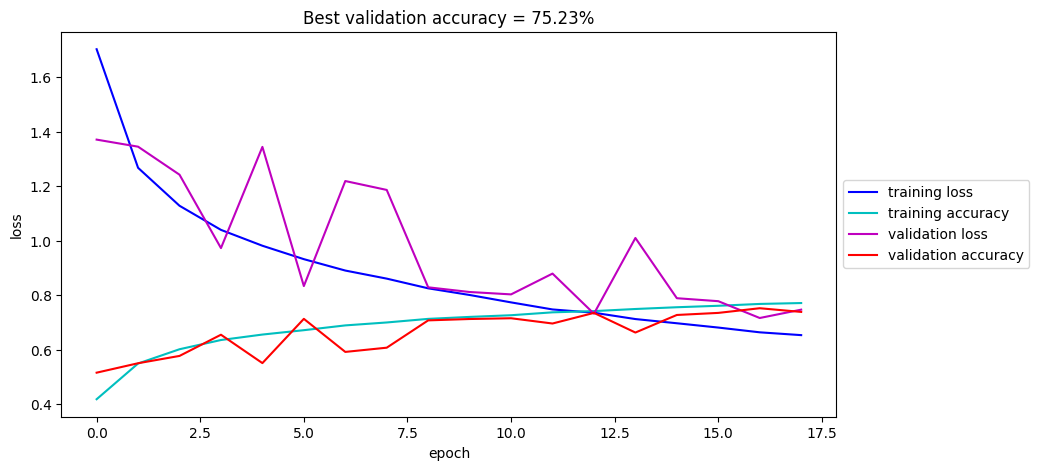

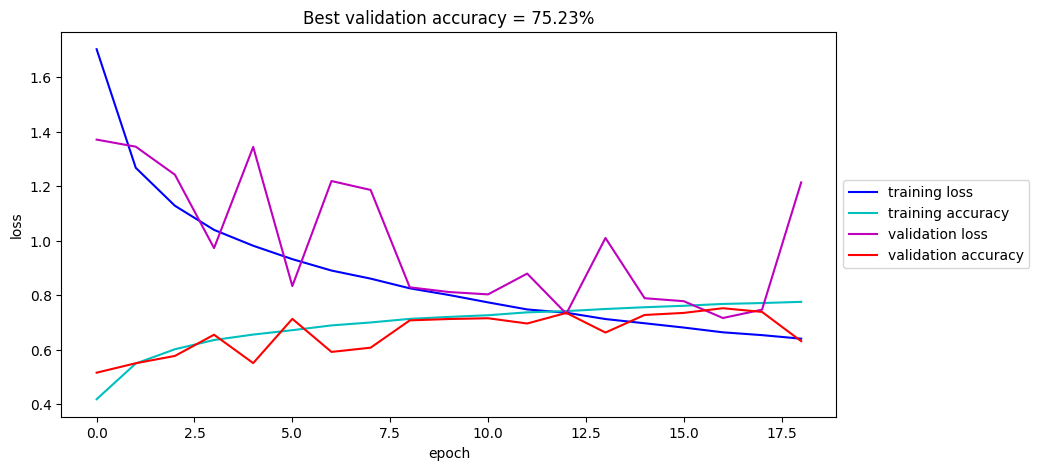

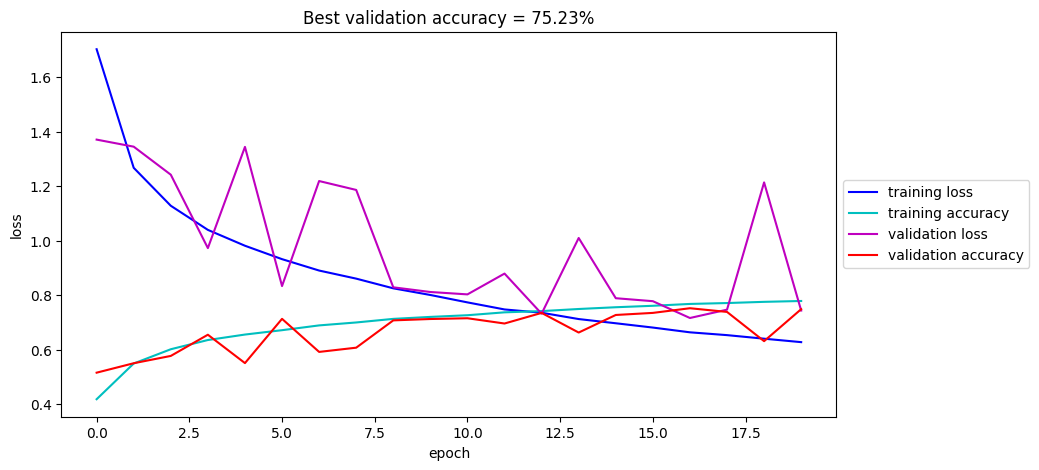

In [ ]:
# Train the network and display results
train_network(network, train_x, train_y_one_hot, val_x, val_y_one_hot, n_epoch, batch_size, network_filepath)


In [ ]:
# Load the best saved model
best_network = keras.models.load_model(network_filepath)
test_prediction = best_network.predict(test_x, batch_size=128)
test_y = np.argmax(test_prediction, axis=1)

# Write CSV file with outputs
network_name = 'network_task_2'
ho = open(f'./results_{network_name}.csv', 'w')
ho.write('filename, label\n')
for filename, label in zip(batches['cifar10-test']['filenames'], test_y):
    ho.write(f'{filename}, {label}\n')
ho.close()


79/79 [==============================] - 0s 3ms/step


# Define Data Augmentation
Define an ImageDataGenerator object with various augmentation techniques.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
# More Aggressive Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Define the Network

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)

    return x

Visualize Training Results

In [ ]:
def build_optimized_model(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

Implement the learning rate schedule:

In [ ]:
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 75:
        lr *= 0.5e-3
    elif epoch > 50:
        lr *= 1e-3
    elif epoch > 25:
        lr *= 1e-2
    return lr

In [ ]:
model = build_optimized_model((32, 32, 3), 10)
optimizer = optimizers.Adam(learning_rate=lr_schedule(0))
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = callbacks.LearningRateScheduler(lr_schedule)
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

In [ ]:


def build_optimized_model(data_size_in, n_classes):
    inputs = layers.Input(shape=data_size_in)

    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = residual_block(x, 64) # Make sure 'residual_block' is defined elsewhere
    x = residual_block(x, 64)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x, 128)
    x = residual_block(x, 128)
    x = layers.MaxPooling2D()(x)

    x = residual_block(x, 256)
    x = residual_block(x, 256)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    # Use tf.keras.models.Model to create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
epochs = 10
batch_size = 64

history = model.fit(
    datagen.flow(train_x, train_y_one_hot, batch_size=batch_size),
    steps_per_epoch=len(train_x) // batch_size,
    epochs=epochs,
    validation_data=(val_x, val_y_one_hot),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
625/625 [==============================] - 40s 64ms/step - loss: 0.2731 - accuracy: 0.9082 - val_loss: 0.4256 - val_accuracy: 0.8674 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 37s 59ms/step - loss: 0.2572 - accuracy: 0.9141 - val_loss: 0.4270 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 38s 60ms/step - loss: 0.2512 - accuracy: 0.9156 - val_loss: 0.3198 - val_accuracy: 0.8957 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 39s 63ms/step - loss: 0.2437 - accuracy: 0.9166 - val_loss: 0.5288 - val_accuracy: 0.8606 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 39s 63ms/step - loss: 0.2363 - accuracy: 0.9202 - val_loss: 0.4587 - val_accuracy: 0.8654 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 40s 63ms/step - loss: 0.2285 - accuracy: 0.9227 - val_loss: 0.3866 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 7/10
625/625 [==============================] - 38s 

In [ ]:
test_loss, test_acc = model.evaluate(test_x, test_y_one_hot, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.8948


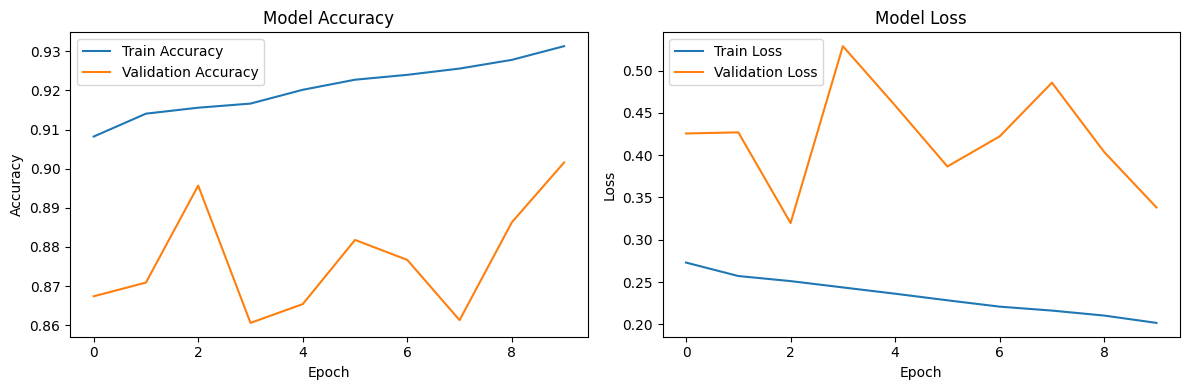

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Tools to monitor training procedure:

In [ ]:
from cv2 import resize
from matplotlib import pyplot
from tensorflow.keras.applications.vgg16 import preprocess_input
%matplotlib inline

Set up the model compilation and callbacks:

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy # Import the loss function

model = build_neural_network(data_size_in, n_classes)

# Define the loss function, optimizer, and metrics
loss = CategoricalCrossentropy()  # Example: Using categorical crossentropy for multi-class classification
sgd = SGD()
metrics = ['accuracy']

model.compile(loss=loss, optimizer=sgd, metrics=metrics)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_84 (Conv2D)          (None, 8, 8, 128)         2049

In [ ]:
for layer in model.layers:
# check for convolutional layer
    if 'conv' not in layer.name:
        continue
# get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_82 (5, 5, 3, 32)
conv2d_83 (5, 5, 32, 64)
conv2d_84 (5, 5, 64, 128)


In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

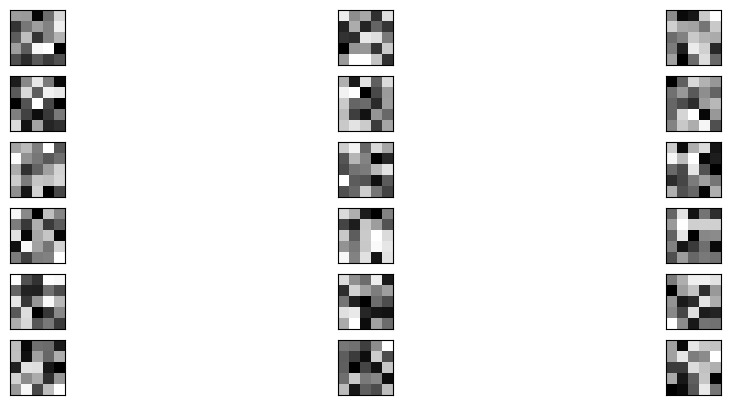

In [ ]:
# plot first few filters

n_filters, ix = 6, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure

pyplot.show()

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from skimage.measure import block_reduce
import cv2

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from numpy import expand_dims

model = Model(inputs=model.inputs, outputs=model.layers[1].output)
model.summary()
# load the image with the required shape
# Update the path to the correct location of your image
img_path = 'path/to/your/image.jpg'  # Replace with the actual path to your image
img = load_img(img_path, target_size=(224, 224))
# convert the image to an array
img = img_to_array(img)
img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
    # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_82 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
Total params: 2432 (9.50 KB)
Trainable params: 2432 (9.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


FileNotFoundError: [Errno 2] No such file or directory: 'path/to/your/image.jpg'